### 🖋 **Notebook Contents**

0. Initial Setup
1. Feature Engineering
1. Modelling
    - Benchmark Model
    - Hyperparameter Tuning
    - Final Model
2. Cluster Analysis
3. Conclusion
4. Recommendation

****

## `Initial Setup`

In [59]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, KernelPCA # dimensional reduction
import plotly.express as px

# preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, RobustScaler, StandardScaler
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import KBinsDiscretizer

# mlflow and dagshub tracking
import mlflow
import dagshub

# get experiment_id for mlflow
sys.path.append(os.path.abspath("../src/"))
from get_or_create_mlflow_experiments import get_experiment_id
EXP_ID = get_experiment_id('Credit_Card_Clustering') # experiment id

# model
from sklearn.cluster import KMeans, MeanShift # centroid-based
from sklearn.cluster import DBSCAN, OPTICS # density-based
from sklearn.cluster import AgglomerativeClustering # hierarchical-based
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import Birch # hierarchical-based
from hdbscan import HDBSCAN # hierarchical density-based

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score # metric evaluation

# CSS properties untuk highlight DataFrame
PROPS = 'color:#080808;font-weight:bold;background-color:#85bb65'

import warnings
warnings.filterwarnings('ignore')

In [60]:
# dagshub and mlflow setup
DAGSHUB_USERNAME = 'fnkhairudin'
DAGSHUB_EMAIL = 'fnkhairudin@gmail.com'
DAGSHUB_REPO = 'Credit-Card-Clustering-Customer-Segmentation'
DAGSHUB_TOKEN = 'b1b10b82350be145d4ea4d0d14d8514de68ae6cf' # dagshub.auth.get_token()
DASGHUB_URI = f'https://dagshub.com/{DAGSHUB_USERNAME}/{DAGSHUB_REPO}.mlflow'

os.environ['MLFLOW_TRACKING_USERNAME'] = DAGSHUB_USERNAME
os.environ['MLFLOW_TRACKING_PASSWORD'] = DAGSHUB_TOKEN
os.environ['MLFLOW_TRACKING_URI'] = DASGHUB_URI

**_Note:_**
Proses modelling akan menggunakan dagshub x mlflow sebagai _experiment tracking_. [Komposisi experiment](https://tidal-knave-1ab.notion.site/Experiment-of-Modelling-List-6ae52ad8d74540e497bce482ec108fd3?pvs=4) dan [hasil experiment](https://dagshub.com/fnkhairudin/Credit-Card-Clustering-Customer-Segmentation.mlflow/#/experiments/0?searchFilter=&orderByKey=attributes.start_time&orderByAsc=false&startTime=ALL&lifecycleFilter=Active&datasetsFilter=W10%3D&modelVersionFilter=All%20Runs&selectedColumns=attributes.%60Models%60,metrics.%60calinski_harabasz%60,metrics.%60davies_bouldin%60,metrics.%60silhouette%60,tags.%60model_name%60,tags.%60experiment-n%60&compareRunCharts=W3sidXVpZCI6IjE2OTcwMjY1NTQxNTI3OXUzcmdkOSIsInR5cGUiOiJCQVIiLCJydW5zQ291bnRUb0NvbXBhcmUiOjEwLCJtZXRyaWNLZXkiOiJjYWxpbnNraV9oYXJhYmFzeiJ9LHsidXVpZCI6IjE2OTcwMjY1NTQxNTNiN3d2NWI1MyIsInR5cGUiOiJCQVIiLCJydW5zQ291bnRUb0NvbXBhcmUiOjEwLCJtZXRyaWNLZXkiOiJzaWxob3VldHRlIn0seyJ1dWlkIjoiMTY5NzAyNjU1NDE1M3hydXlybHp1IiwidHlwZSI6IkJBUiIsInJ1bnNDb3VudFRvQ29tcGFyZSI6MTAsIm1ldHJpY0tleSI6ImRhdmllc19ib3VsZGluIn0seyJ1dWlkIjoiMTY5NzAyNjU1NDE1M3Jyc2hwd2ExIiwidHlwZSI6IlBBUkFMTEVMIiwicnVuc0NvdW50VG9Db21wYXJlIjoxMCwic2VsZWN0ZWRQYXJhbXMiOltdLCJzZWxlY3RlZE1ldHJpY3MiOltdfV0%3D) dapat diakses pada link tersebut. Jika link erorr, cukup refresh link kembali.

In [4]:
# load dataset
data = pd.read_csv("../data/processed/clean_cc_data.csv")
# data.sample(5)

In [20]:
print(f'Jumlah baris dan kolom: {data.shape[0]} baris dan {data.shape[1]} kolom')

# skimming dataset
pd.DataFrame(
                {
                'kolom': data.columns.values,
                'data_type': data.dtypes.values,
                'null_value(%)': data.isna().mean().values * 100,
                'n_unique': data.nunique().values,
                'zero_value' : [True if (data[col] == 0).any() else False for col in data.columns],
                'neg_value' : [True if (data[col].dtype == int or data[col].dtype == float) and (data[col] < 0).any() else False for col in data.columns],
                'min': data.min().values,
                'max': data.max().values,
                'sample_unique': [data[col].unique() for col in data.columns]
                }
            )

Jumlah baris dan kolom: 8950 baris dan 17 kolom


kolom data_type  null_value(%)  n_unique  \
0                            BALANCE   float64            0.0      8871   
1                  BALANCE_FREQUENCY   float64            0.0        43   
2                          PURCHASES   float64            0.0      6203   
3                   ONEOFF_PURCHASES   float64            0.0      4014   
4             INSTALLMENTS_PURCHASES   float64            0.0      4452   
5                       CASH_ADVANCE   float64            0.0      4323   
6                PURCHASES_FREQUENCY   float64            0.0        47   
7         ONEOFF_PURCHASES_FREQUENCY   float64            0.0        47   
8   PURCHASES_INSTALLMENTS_FREQUENCY   float64            0.0        47   
9             CASH_ADVANCE_FREQUENCY   float64            0.0        47   
10                  CASH_ADVANCE_TRX   float64            0.0        65   
11                     PURCHASES_TRX   float64            0.0       173   
12                      CREDIT_LIMIT   float64            0.0       206   
13                          PAYMENTS   float64            0.0      8711   
14                  MINIMUM_PAYMENTS   float64            0.0      8931   
15                  PRC_FULL_PAYMENT   float64            0.0        47   
16                            TENURE   float64            0.0         7   

    zero_value  neg_value        min          max  \
0         True      False   0.000000  19043.13856   
1         True      False   0.000000      1.00000   
2         True      False   0.000000  49039.57000   
3         True      False   0.000000  40761.25000   
4         True      False   0.000000  22500.00000   
5         True      False   0.000000  47137.21176   
6         True      False   0.000000      1.00000   
7         True      False   0.000000      1.00000   
8         True      False   0.000000      1.00000   
9         True      False   0.000000      1.00000   
10        True      False   0.000000    123.00000   
11        True      False   0.000000    358.00000   
12       False      False  50.000000  30000.00000   
13        True      False   0.000000  50721.48336   
14       False      False   0.019163  76406.20752   
15        True      False   0.000000      1.00000   
16       False      False   6.000000     12.00000   

                                        sample_unique  
0   [40.900749, 3202.467416, 2495.148862, 1666.670...  
1   [0.818182, 0.909091, 1.0, 0.636364, 0.545455, ...  
2   [95.4, 0.0, 773.17, 1499.0, 16.0, 1333.28, 709...  
3   [0.0, 773.17, 1499.0, 16.0, 6402.63, 661.49, 1...  
4   [95.4, 0.0, 1333.28, 688.38, 436.2, 200.0, 920...  
5   [0.0, 6442.945483, 205.788017, 346.81139, 2301...  
6   [0.166667, 0.0, 1.0, 0.083333, 0.666667, 0.333...  
7   [0.0, 1.0, 0.083333, 0.166667, 0.25, 0.916667,...  
8   [0.083333, 0.0, 0.583333, 1.0, 0.25, 0.916667,...  
9   [0.0, 0.25, 0.083333, 0.166667, 0.333333, 0.36...  
10  [0.0, 4.0, 1.0, 3.0, 6.0, 13.0, 5.0, 16.0, 10....  
11  [2.0, 0.0, 12.0, 1.0, 8.0, 64.0, 5.0, 3.0, 6.0...  
12  [1000.0, 7000.0, 7500.0, 1200.0, 1800.0, 13500...  
13  [201.802084, 4103.032597, 622.066742, 0.0, 678...  
14  [139.509787, 1072.340217, 627.284787, 379.8299...  
15  [0.0, 0.222222, 1.0, 0.25, 0.083333, 0.3, 0.33...  
16             [12.0, 8.0, 11.0, 9.0, 10.0, 7.0, 6.0]

In [5]:
# dataset untuk modelling
data_modelling = data.copy()

## `Feature Engineering (Experiment)`

In [88]:
# from sklearn.preprocessing import KBinsDiscretizer

# # freq column
# freq_column = ['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',\
#                'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'PRC_FULL_PAYMENT']

# # binning menggunakan kmeans
# kbins = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')

# data_modelling[freq_column] = kbins.fit_transform(data_modelling[freq_column])
# data_modelling.describe()

BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           2.656760   1003.204834        592.437371   
std     2081.531879           0.769398   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           3.000000     39.635000          0.000000   
50%      873.385231           3.000000    361.280000         38.000000   
75%     2054.140036           3.000000   1110.130000        577.405000   
max    19043.138560           3.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             1.487821   
std                904.338115   2097.163877             1.293812   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.000000   
50%                 89.000000      0.000000             2.000000   
75%                468.637500   1113.821139             3.000000   
max              22500.000000  47137.211760             3.000000   

       ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
count                 8950.000000                       8950.000000   
mean                     0.571061                          1.075084   
std                      0.972772                          1.251194   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.000000                          0.000000   
75%                      1.000000                          2.000000   
max                      3.000000                          3.000000   

       CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
count             8950.000000       8950.000000    8950.000000   8950.000000   
mean                 0.368492          0.185810       0.271955   4494.179679   
std                  0.707913          0.450475       0.547657   3638.701915   
min                  0.000000          0.000000       0.000000     50.000000   
25%                  0.000000          0.000000       0.000000   1600.000000   
50%                  0.000000          0.000000       0.000000   3000.000000   
75%                  1.000000          0.000000       0.000000   6500.000000   
max                  3.000000          3.000000       3.000000  30000.000000   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT       TENURE  
count   8950.000000       8950.000000       8950.000000  8950.000000  
mean    1733.143852        852.716172          0.433855    11.517318  
std     2895.063757       2347.654983          0.904808     1.338331  
min        0.000000          0.019163          0.000000     6.000000  
25%      383.276166        166.310858          0.000000    12.000000  
50%      856.901546        300.956126          0.000000    12.000000  
75%     1901.134317        804.414788          0.000000    12.000000  
max    50721.483360      76406.207520          3.000000    12.000000

In [89]:
# # continous columns
# cont_column = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']
# ss = StandardScaler()
# rs = RobustScaler()
# mm = MinMaxScaler()
# # ct = ColumnTransformer([
# # ('OneHot', OneHotEncoder(), cont_column)
# # ], remainder='passthrough')

# data_modelling[cont_column] = rs.fit_transform(data_modelling[cont_column])
# data_modelling.describe()

BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count  8.950000e+03        8950.000000  8.950000e+03       8950.000000   
mean   3.588476e-01           2.656760  5.996523e-01          0.960223   
std    1.080833e+00           0.769398  1.995932e+00          2.874738   
min   -4.535045e-01           0.000000 -3.374887e-01         -0.065812   
25%   -3.868942e-01           3.000000 -3.004638e-01         -0.065812   
50%    2.951740e-17           3.000000  2.653585e-17          0.000000   
75%    6.131058e-01           3.000000  6.995362e-01          0.934188   
max    9.434627e+00           3.000000  4.547269e+01         70.528052   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean                 0.687243      0.878840             1.487821   
std                  1.929718      1.882855             1.293812   
min                 -0.189912      0.000000             0.000000   
25%                 -0.189912      0.000000             0.000000   
50%                  0.000000      0.000000             2.000000   
75%                  0.810088      1.000000             3.000000   
max                 47.821611     42.320270             3.000000   

       ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
count                 8950.000000                       8950.000000   
mean                     0.571061                          1.075084   
std                      0.972772                          1.251194   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.000000                          0.000000   
75%                      1.000000                          2.000000   
max                      3.000000                          3.000000   

       CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
count             8950.000000       8950.000000    8950.000000   8950.000000   
mean                 0.368492          0.185810       0.271955      0.304935   
std                  0.707913          0.450475       0.547657      0.742592   
min                  0.000000          0.000000       0.000000     -0.602041   
25%                  0.000000          0.000000       0.000000     -0.285714   
50%                  0.000000          0.000000       0.000000      0.000000   
75%                  1.000000          0.000000       0.000000      0.714286   
max                  3.000000          3.000000       3.000000      5.510204   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT       TENURE  
count  8.950000e+03       8950.000000       8950.000000  8950.000000  
mean   5.772887e-01          0.864687          0.433855    11.517318  
std    1.907335e+00          3.679111          0.904808     1.338331  
min   -5.645465e-01         -0.471611          0.000000     6.000000  
25%   -3.120353e-01         -0.211008          0.000000    12.000000  
50%   -3.744563e-17          0.000000          0.000000    12.000000  
75%    6.879647e-01          0.788992          0.000000    12.000000  
max    3.285194e+01        119.267799          3.000000    12.000000

## `Modelling`

In [6]:
# raw df
raw_df = pd.read_csv("../data/raw/CC GENERAL.csv").drop(columns='CUST_ID')
# raw_df.sample(5)

### 2.1. Benchmark Model

Melakukan _training_ pada beberapa model dengan komposisi dataset yang telah melewati _preprocessing_ menggunakan _pipeline_. Kemudian, hasil training tersebut akan dievaluasi berdasarkan hasil metrik evaluasinya. Metrik evaluasi yang digunakan adalah _silhouette score_, _Davies Bouldin Index (DBI)_, dan _Calinski-Harabasz Index (CH)_. Selain itu, hasil training model juga akan dilihat dari plot _cluster_ yang terbentuk. Selanjutnya, akan memilih 3 model terbaik yang akan dilakukan _hyperparameter tuning_

Kolom-kolom yang bersifat frekuensi seperti BALANCE_FREQUENCY, PURCHASES_FREQUENCY, ONEOFF_PURCHASES_FREQUENCY, dsb akan dilakukan _binning_. Sedangkan, kolom-kolom yang bersifat _continue_ akan dilakukan **scaling** ulang. Kemudian, untuk _handling missing values_ menggunakan KNNImputer. Hal ini dilakukan agar model diharapkan memiliki tingkat skalabilitas yang tinggi dan model memiliki performa yang lebih baik.

In [31]:
# continue column
cont_column = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']
# frequency column
freq_column = ['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',\
              'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'PRC_FULL_PAYMENT']

# ColumnTransformer untuk scaling
ct_1 = ColumnTransformer([
                ('scaler', RobustScaler(), cont_column),
                ], remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')
# ColumnTransformer untuk binning
ct_2 = ColumnTransformer([
                ('binning', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans'), freq_column)
                ], remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

In [32]:
# fungsi untuk melakukan model training
def log_training_model(est, 
                       model_name:str, 
                       score_result:list, 
                       dataset:pd.DataFrame, 
                       name_experiment:str, 
                       #col_transformer,
                       ):
    """
    est : Estimator object
    model_name : Estimator name
    score_result : Empty list to store the metric result
    dataset : Dataset for training the estimator
    name_experiment : experiment name
    col_transformer : ColumnTranformer
    """
    # model params
    model_params = est.get_params()
    # parameters mlflow ui
    mlflow.log_params(model_params)

    # pipeline
    pipe = Pipeline([
                ('preprocess_1', ct_1), # scaling
                ('imputer', KNNImputer(n_neighbors=5)), # imputer
                ('preprocess_2', ct_2), # binning
                ('model', est)
                ]).set_output(transform='pandas')
    
    # dataset yang sudah melewati pipeline[:-1] yang akan digunakan untuk proses scoring
    data_scoring = pipe[:-1].fit_transform(dataset)[dataset.columns]
    
    print(f"training model {model_name} ......")
    # hasil cluster untuk masing-masing point data
    result = pipe.fit_predict(dataset)

    # set_tag
    tags = {"model_name": model_name, 'jumlah_cluster' : len(set(result)), "experiment-n": name_experiment,}
    # tags untuk mlflow ui
    mlflow.set_tags(tags)

    # jika terbentuk HANYA 1 cluster --> metric evaluation tidak bisa melakukan perhitungan
    if len(np.unique(result)) == 1:
        score_result.append({
        'Model' : model_name,
        'silhouette_score': np.nan,
        'calinski_harabasz_score': np.nan,
        'davies_bouldin_score': np.nan,
        'jumlah_cluster' : len(set(result))
        })
        # log metrics pada mlflow ui
        mlflow.log_metrics({
                'silhouette': np.float('nan'),
                'calinski_harabasz': np.float('nan'),
                'davies_bouldin': np.float('nan'),
                })
        # log model pada mlflow ui
        mlflow.sklearn.log_model(est, "sk_model")

    # jika terbentuk lebih dari 1 cluster
    else:
        # hasil clustering
        score_result.append({
        'Model' : model_name,
        'silhouette_score': silhouette_score(data_scoring, result),
        'calinski_harabasz_score': calinski_harabasz_score(data_scoring, result),
        'davies_bouldin_score': davies_bouldin_score(data_scoring, result),
        'jumlah_cluster' : len(set(result))
        })
        # log metrics pada mlflow ui
        mlflow.log_metrics({
                        'silhouette': silhouette_score(data_scoring, result),
                        'calinski_harabasz': calinski_harabasz_score(data_scoring, result),
                        'davies_bouldin': davies_bouldin_score(data_scoring, result),
                        })
        # log model pada mlflow ui
        mlflow.sklearn.log_model(est, "sk_model")
    print(f"training model {model_name} is DONE.")

In [27]:
# model
kmeans = KMeans(n_clusters=4)
meanshift = MeanShift()
dbscan = DBSCAN()
optics = OPTICS()
agglomerative = AgglomerativeClustering(n_clusters=4)
# affinity = AffinityPropagation()
birch = Birch(n_clusters=4)
hdbscan = HDBSCAN()

In [37]:
# collect model
model = {
    'KMeans': kmeans,
    'MeanShift': meanshift,
    'DBSCAN': dbscan,
    'OPTICS': optics,
    'AgglomerativeClustering': agglomerative,
    # 'AffinityPropagation': affinity,
    'Birch' : birch,
    'HDBSCAN' : hdbscan
}

# hasil metrik evaluasi
metric_result = []

# melakukan set up the mlflow uri untuk tracking hasil eksperiment
mlflow.set_tracking_uri(DASGHUB_URI)

# melakukan tracking eksperiment menggunakan mlflow
for name, estimator in model.items(): 
    with mlflow.start_run(experiment_id=EXP_ID):
        # call fungsi untuk training model dan logging di mlflow
        log_training_model(est=estimator, 
                           model_name=name, 
                           score_result=metric_result, 
                           dataset=raw_df, 
                           name_experiment='experiment-pipeline-10'
                           #col_transformer=ct
                           )

training model KMeans ......
training model KMeans is DONE.
training model MeanShift ......
training model MeanShift is DONE.
training model DBSCAN ......


2023/10/14 15:32:56 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model DBSCAN is DONE.
training model OPTICS ......


2023/10/14 15:33:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model OPTICS is DONE.
training model AgglomerativeClustering ......


2023/10/14 15:34:18 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering is DONE.
training model Birch ......
training model Birch is DONE.
training model HDBSCAN ......


2023/10/14 15:35:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model HDBSCAN is DONE.


In [38]:
# tampilkan hasil training model dalam bentuk DataFrame
metric_result_df = pd.DataFrame(metric_result).style.\
    highlight_min(subset='davies_bouldin_score', props=PROPS).\
    highlight_max(subset=['silhouette_score', 'calinski_harabasz_score'], props=PROPS)
metric_result_df

**_Insight_**:
- Berdasarkan metrik evaluasi hasil _training model_ di atas, maka top 3 model yang menghasilkan model terbaik:
    - Model **Kmeans** dengan nilai metrik _silhouette score_ sebesar 0.44, _calinski harabasz score_ sebesar 2137.56, dan _davies bouldin score_ sebesar 1.031
    - Model **AgglomerativeClustering** dengan nilai metrik _silhouette score_ sebesar 0.49, _calinski harabasz score_ sebesar 1890.719, dan _davies bouldin score_ sebesar 0.969
    - Model **Birch** dengan nilai metrik _silhouette score_ sebesar 0.666, _calinski harabasz score_ sebesar 1752.971, dan _davies bouldin score_ sebesar 0.840
- Kemudian juga akan dilihat bagaimana hasil _clustering_ masing-masing model melalui **plot visualiasi 2 dimensi** dengan pendekatan menggunakan metode **_dimenstional reduction_**
- Berdasarkan hasil _experiment_, komposisi _experiment_ di atas cenderung memiliki nilai metrik evaluasi yang bagus pada semua model. Namun, model yang berbasis densitas selalu cenderung memiliki nilai metrik evaluasi yang lebih buruk daripada model lainnya
- .....
- .....

#### 2.1.1. Visualisasi Cluster

In [39]:
# top 3 model --> Kmeans, Agglomerative, Birch --> predict ke raw dataset
# top_3_model = {
#     'KMeans': kmeans,
#     'MeanShift': meanshift,
#     'DBSCAN': dbscan,
#     'OPTICS': optics,
#     'AgglomerativeClustering': agglomerative,
#     # 'AffinityPropagation': affinity,
#     'Birch' : birch,
#     'HDBSCAN' : hdbscan
# }

# hasil cluster masing2 model
clust_kmeans, clust_agglo, clust_birch, clust_meanshift, clust_dbscan, clust_optics, clust_hdbscan = [],[],[],[],[],[],[]

for name, est in model.items():
    # pipeline yang digunakan untuk training model
    pipe = Pipeline([
            ('preprocess_1', ct_1), # scaling
            ('imputer', KNNImputer(n_neighbors=5)), # imputer
            ('preprocess_2', ct_2), # binning
            ('model', est)
            ]).set_output(transform='pandas')
    
    # hasil cluster masing2 model
    result = pipe.fit_predict(raw_df)
    
    # masukkan hasil cluster ke dalam masing2 empty list
    if name == 'KMeans':
        clust_kmeans = result
    elif name == 'AgglomerativeClustering':
        clust_agglo = result
    elif name == 'Birch':
        clust_birch = result
    elif name == 'OPTICS':
        clust_optics = result
    elif name == 'MeanShift':
        clust_meanshift = result
    elif name == 'DBSCAN':
        clust_dbscan = result
    elif name == 'HDBSCAN':
        clust_hdbscan = result

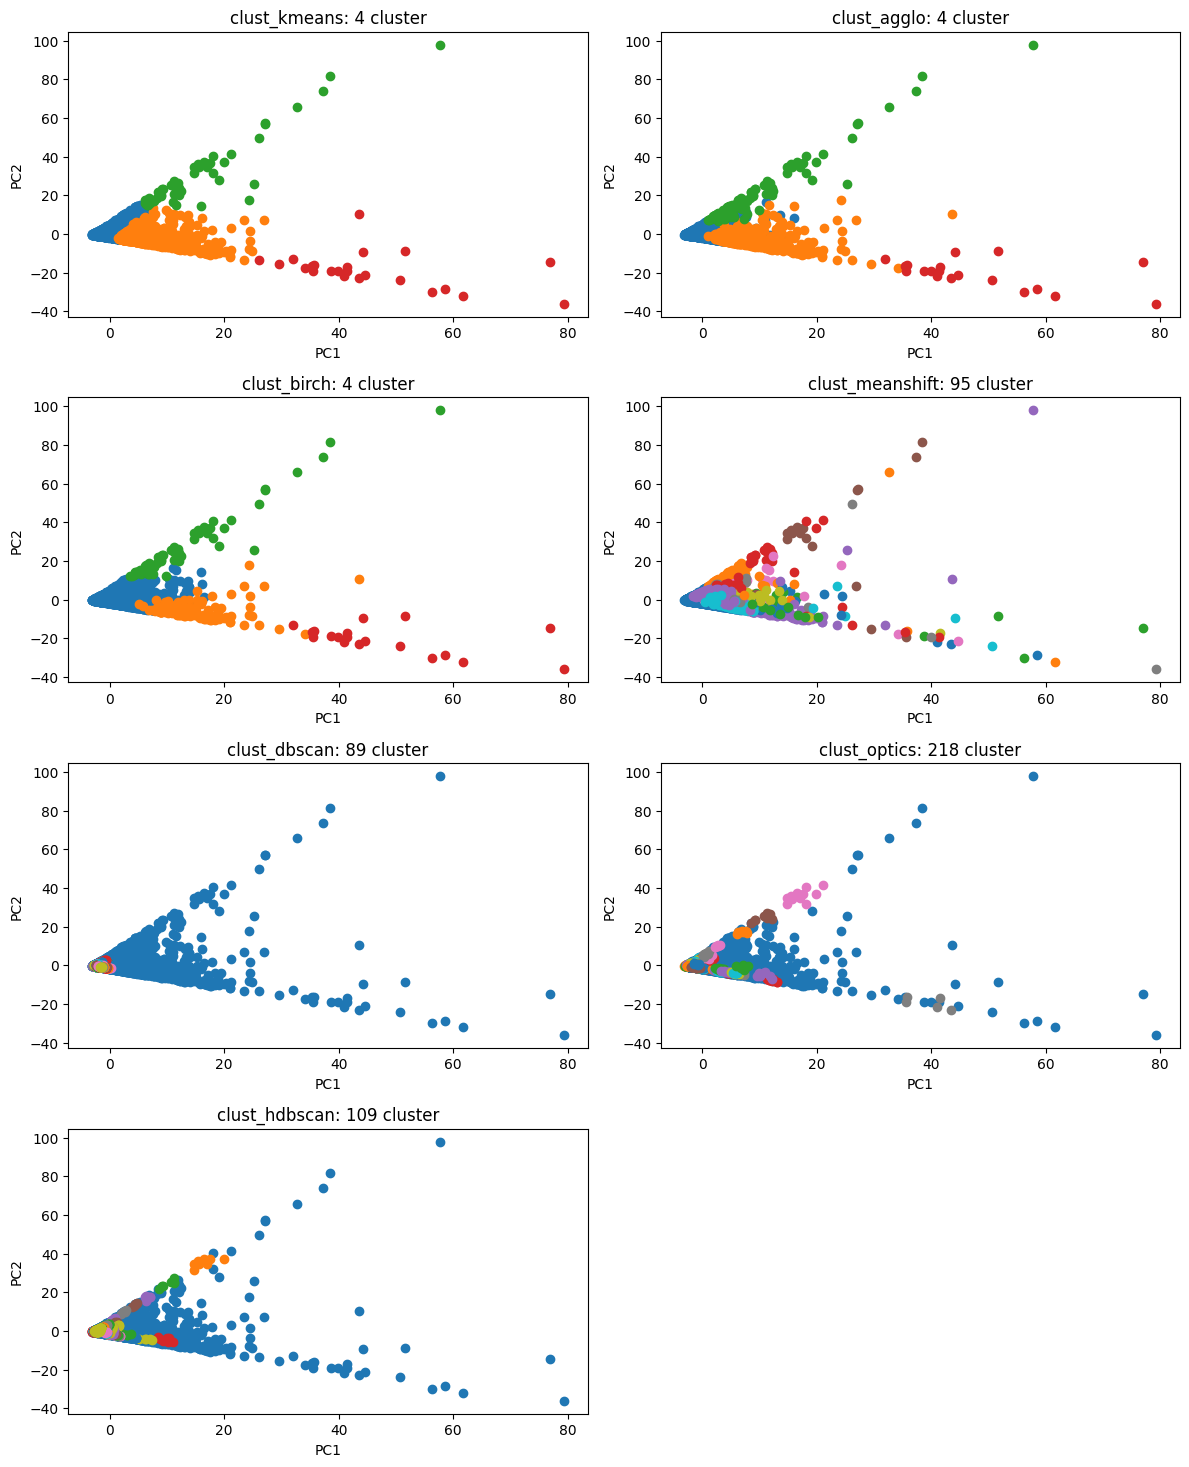

In [40]:
# dimensional reduction menggunakan KernelPCA

# pipeline preprocessing
pipe = Pipeline([
        ('preprocess_1', ct_1), # scaling
        ('imputer', KNNImputer(n_neighbors=5)), # imputer
        ('preprocess_2', ct_2), # binning
        ]).set_output(transform='pandas')

# 2D PCA
pca = KernelPCA(n_components=2)
# dataset yang sudah melewati preprocessing
data_norm = pipe.fit_transform(raw_df)
# dataset dataset yang sudah melewati preprocessing dan dilakukan PCA
data_pca = pca.fit_transform(data_norm)

# letak plot
count = 0
# ukuran canvas
fig = plt.figure(figsize=(12, 18))
# plot hasil masing-masing clustering
for i in ['clust_kmeans', 'clust_agglo', 'clust_birch', 'clust_meanshift', 'clust_dbscan', 'clust_optics', 'clust_hdbscan']:
    count +=1
    ax = plt.subplot(5,2,count)
    # get unique cluster
    unique_clust = np.unique(eval(i))
    for j in unique_clust:
        plt.scatter(data_pca[eval(i) == j, 0], data_pca[eval(i) == j, 1],)
    
    plt.title(f"{i}: {len(unique_clust)} cluster")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    fig.tight_layout()
    # plt.legend()
plt.show()

In [42]:
# plot using 3D PCA
pca = KernelPCA(n_components=3, random_state=22, n_jobs=-1) 
data_pca_3d = pca.fit_transform(data_norm)

for clust in ['clust_kmeans', 'clust_agglo', 'clust_birch', 'clust_meanshift', 'clust_dbscan', 'clust_optics', 'clust_hdbscan']:
    # DataFrame untuk plot
    df_plot = pd.DataFrame(data_pca_3d, columns=['PC1', 'PC2', 'PC3'])
    df_plot['Cluster'] = eval(clust)

    # plot 3D
    fig = px.scatter_3d(data_frame=df_plot, x='PC1', y='PC2', z='PC3',
                color='Cluster', color_continuous_scale=px.colors.sequential.Hot, title=f'Plot 3D {clust}: {len(set(eval(clust)))} cluster')
    fig.show();

**_Insight_**:
- Berdasarkan hasil metrik evaluasi dan grafik hasil _clustering_, maka akan dipilih 3 top model yang selanjutnya akan dilakukan **Hyperparameter Tuning**, yaitu:
    - Model **Kmeans**
    - Model **Agglomerative Clustering**
    - Model **Birch**
- Setelah dilakukan _hyperparameter tuning_, akan dipilih 1 model terbaik
- ......
- ......

dst

### 2.2. Hyperparameter Tuning

Hyperparameter Tuning adalah proses .....

#### 2.2.1. Kmeans

In [81]:
# def test(name,**kwargs):
#     typex = kwargs['typex']
#     adjective = kwargs['adjective']
    
#     if typex == 'cat':
#         print(f"{name} is a {adjective} {typex}.")
        
#     elif typex == 'human':
#         gender = kwargs['gender']
        
#         print(f"{name} is a {adjective} {gender}.")
    
#     elif typex == None and adjective == None:
#         print(f"{name}")
    
# test(name='meowsie', typex=None, adjective=None)

meowsie


In [53]:
n_clust_kmeans = list(range(2,11))
n_max_iter = list(range(300,600,100))

# empty list untuk menyimpan hasil tuning KMeans
score_kmeans_tuned = []
# Melakukan Hyperparameter Tuning KMeans
for n_clust in n_clust_kmeans: # jumlah cluster
    for n_iter in n_max_iter: # jumlah iterasi
        kmeans_tune = KMeans(n_clusters=n_clust, max_iter=n_iter, algorithm='lloyd', random_state=0)
        # logging pada mlflow
        with mlflow.start_run(experiment_id=EXP_ID):
            log_training_model(kmeans_tune, 
                            model_name='Kmeans-Tuned',
                            score_result=score_kmeans_tuned,
                            dataset=raw_df,
                            name_experiment='Kmeans-Tuned'
                            )

training model Kmeans-Tuned ......
training model Kmeans-Tuned is DONE.
training model Kmeans-Tuned ......
training model Kmeans-Tuned is DONE.
training model Kmeans-Tuned ......
training model Kmeans-Tuned is DONE.
training model Kmeans-Tuned ......
training model Kmeans-Tuned is DONE.
training model Kmeans-Tuned ......
training model Kmeans-Tuned is DONE.
training model Kmeans-Tuned ......
training model Kmeans-Tuned is DONE.
training model Kmeans-Tuned ......
training model Kmeans-Tuned is DONE.
training model Kmeans-Tuned ......
training model Kmeans-Tuned is DONE.
training model Kmeans-Tuned ......
training model Kmeans-Tuned is DONE.
training model Kmeans-Tuned ......
training model Kmeans-Tuned is DONE.
training model Kmeans-Tuned ......
training model Kmeans-Tuned is DONE.
training model Kmeans-Tuned ......
training model Kmeans-Tuned is DONE.
training model Kmeans-Tuned ......
training model Kmeans-Tuned is DONE.
training model Kmeans-Tuned ......
training model Kmeans-Tuned i

In [63]:
# tampilkan hasil training model dalam bentuk DataFrame
metric_result_kmeans_tuned = pd.DataFrame(score_kmeans_tuned).style.\
    highlight_min(subset='davies_bouldin_score', props=PROPS).\
    highlight_max(subset=['silhouette_score', 'calinski_harabasz_score'], props=PROPS)
metric_result_kmeans_tuned['n_max_iter'] = ['']

**_Insight_**:
- Berdasarkan hasil [**hyperparameter tuning**](https://dagshub.com/fnkhairudin/Credit-Card-Clustering-Customer-Segmentation.mlflow), Kmeans dengan **3 cluster dan max_iter baik 300, 400, maupun 500** memiliki nilai metrik evaluasi yang lebih baik daripada yang lainnya dengan nilai _silhoutte score_ sebesar 0.6, _davies bouldin score_ sebesar 1.026, dan _calinski harabasz score_ sebesar 2112.6.

#### 2.2.2. Agglomerative Clustering

In [61]:
n_clust_agglo = list(range(2,11))
linkage = ['ward', 'complete', 'average', 'single']

# empty list untuk menyimpan hasil tuning AgglomerativeClustering
score_agglo_tuned = []
# Melakukan Hyperparameter Tuning AgglomerativeClustering
for n_clus in n_clust_agglo: # jumlah cluster
    for link in linkage: # jenis linkage
        agglo_tune = AgglomerativeClustering(n_clusters=n_clus, linkage=link)
        # logging pada mlflow
        with mlflow.start_run(experiment_id=EXP_ID):
            log_training_model(agglo_tune, 
                            model_name='AgglomerativeClustering-Tuned',
                            score_result=score_agglo_tuned,
                            dataset=raw_df,
                            name_experiment='AgglomerativeClustering-Tuned'
                            )

training model AgglomerativeClustering-Tuned ......


2023/10/14 17:52:12 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 17:53:11 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 17:53:34 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 17:54:14 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 17:54:53 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 17:55:16 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 17:55:32 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 17:56:06 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 17:56:32 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 17:57:24 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 17:58:28 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 17:58:53 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 17:59:21 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 17:59:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:00:11 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:00:31 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:00:46 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:01:13 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:01:32 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:01:48 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:02:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:03:11 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:03:28 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:03:47 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:04:15 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:04:35 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:05:06 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:05:26 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:06:12 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:06:32 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:06:50 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:07:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:08:01 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:08:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:08:42 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.
training model AgglomerativeClustering-Tuned ......


2023/10/14 18:09:08 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


training model AgglomerativeClustering-Tuned is DONE.


In [64]:
# tampilkan hasil training model dalam bentuk DataFrame
metric_result_agglo_tuned = pd.DataFrame(score_agglo_tuned).style.\
    highlight_min(subset='davies_bouldin_score', props=PROPS).\
    highlight_max(subset=['silhouette_score', 'calinski_harabasz_score'], props=PROPS)
metric_result_agglo_tuned

**_Insight_**:
- Berdasarkan hasil [**hyperparameter tuning**](https://dagshub.com/fnkhairudin/Credit-Card-Clustering-Customer-Segmentation.mlflow), AgglomerativeClustering dengan _single linkage_ cenderung memiliki nilai metrik evaluasi yang lebih baik daripada linkage yang lainnya. Kemudian, AgglomerativeClustering yang nilai metrik evaluasinya paling baik adalah dengan **jumlah cluster 3 dan _single linkage_** dengan nilai _silhoutte score_ sebesar 0.916, _davies bouldin score_ sebesar 0.051, dan _calinski harabasz score_ sebesar 239.4.

#### 2.2.3. BIRCH

In [ ]:
n_clust_birch = [2, 3, 4, 5, 6, 7, 8, 9]
threshold = [0.3, 0.5, 0.7]
branching_factor = [30, 40, 50]

# empty list untuk menyimpan hasil tuning Birch
score_birch_tuned = []
# Melakukan Hyperparameter Tuning Birch
for n_clus in n_clust_birch: # jumlah cluster
    for thres in threshold: # threshold
        for branch in branching_factor:
            birch_tune = Birch(n_clusters=n_clus, threshold=thres, branching_factor=branch)
            # logging pada mlflow
            with mlflow.start_run(experiment_id=EXP_ID):
                log_training_model(agglo_tune, 
                                model_name='Birch-Tuned',
                                score_result=score_agglo_tuned,
                                dataset=raw_df,
                                name_experiment='Birch-Tuned-1'
                                )

#### 2.2.4. Membandingkan **Kmeans**, **BIRCH**, dan **Agglomerative Clustering**